# Math PhD EDA

Scott Atkinson

## [0. Contents](#0._Contents) <a id='0._Contents'></a>
## [1. Import libraries and data](#1._Import_libraries_and_data)
## [2. Create advisor table](#2._Create_advisor_table)
* We filter the dataframe obtained in the datawrangling step to only admit entries with at least one student and with publication, year, and student data.

## [3. Career lengths](#3._Career_lengths)
* We create a career length column to allow us to compute rough averages of various features.
* We also create columns for the number of students acquired in 5, 10, 15, 20, 25, 30, 35, and 40 years.

## [4. Boxplots for number of students over various time intervals](#4._Boxplots_for_number_of_students_over_various_time_intervals)
* We create boxplots for each of `num_students` columns created in the previous step.

## [5. Histograms for number of students over various time intervals](#5._Histograms_for_number_of_students_over_various_time_intervals)
* We examine the histograms for each of the `num_students` columns.

## [6. Histograms for number of students acquired over various 5-year intervals](#6._Histograms_for_number_of_students_acquired_over_various_5-year_intervals)
* We create columns giving the increment of students acquired over 5-year intervals and examine their histograms.

## [7. Boxplots for number of students acquired over various 5-year intervals](#7._Boxplots_for_number_of_students_acquired_over_various_5-year_intervals)
* We look at the boxplots for the columns created in the previous step.

## [8. CDFs and PDFs for number of students over various time intervals](#8._CDFs_and_PDFs_for_number_of_students_over_various_time_intervals)
* We take a closer look at the distributions of the `num_students` columns by plotting their CDFs and PDFs.  Apparently the CDFs indicate that their is a close fit with exponential distributions.

## [9. Obtaining more features](#9._Obtaining_more_features)
* We obtain the following features:
    * `Advisor_students`: The number of students the candidate's advisor produced.
    * `School_producers`: This is the ratio of PhDs produced by a school who went on to advise PhD students of their own to the total number of PhDs produced by a school.
    * `pubs_per_year`: Publications per year according to the candidate's career length.
    * `citations_per_year`: Citations per year according to the candidate's career length.

## [10. Obtaining dataframe for advisors with career length at least 20 years](#10._Obtaining_dataframe_for_advisors_with_career_length_at_least_20_years)


## [11. Visualizations of correlations](#11._Visualizations_of_correlations)
* ### [11.1 Heatmap](#11.1_Heatmap)
* ### [11.2 Pairplot](#11.2_Pairplot)
* ### [11.3 Scatter plots with 4 regression curves](#11.3_Scatter_plots_with_4_regression_curves)
* ### [11.4 Aside](#11.4_Aside)

## [12. Categorical analysis](#12._Categorical_analysis)




## 1. Import libraries and data<a id='1._Import_libraries_and_data'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D




import time
import datetime



pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = 13, 13
sns.set()

Applying the operations below is computationally intensive, so we can load the dataframes obtained in this notebook using by running the following cell

In [2]:
ad = pd.read_excel('advisor_table.xlsx')
ad20 = pd.read_excel('advisor20_table.xlsx')

In [ ]:
df = pd.read_excel('../DataWrangling/MGP_MScN.xlsx')

In [ ]:
df.set_index('MGP_ID', inplace = True, drop = False)
df

## 2. Create advisor table (records with at least one student and with publication, year, student data)<a id='2._Create_advisor_table'></a>

In [ ]:
def students(rec):
    stset = []
    for j in range(1,7):
        for stu in df[df['Advisor_%s_MGP_ID'%(j)] == rec].index:
            stset.append(stu)
    return set(stset)

In [ ]:
ad = df[(df['num_students']>0) & (df['Total_Pubs']!= -1) & (df['Year']>0) & (df['Earliest_Pub'] > -1) & (df['num_students'] == df['MGP_ID'].apply(students).apply(len))]
ad.shape

## 3. Career lengths and number of students per year<a id='3._Career_lengths'></a>

The function for career length is given as follows: $$f(x) = \left\{ \begin{array}{lcr} 2020 - x & \text{if} & x \geq 1980\\ \max(L - x) & \text{if} & x < 1980\end{array}\right. $$ where $x$ is the degree year, and $L$ is the degree year of the latest student.

In [ ]:
def career_length(rec):
    x = df.loc[rec,'Year']
    if x == 0:
        x = df.loc[rec,'Earliest_Pub']
        if x == -1:
            return 40
    if x >= 1980:
        return 2020 - x
    elif students(rec) != set():
        stu_years = []
        for stu in students(rec):
            stu_years.append(df.loc[stu, 'Year'])
        L = max(stu_years)
        if L != 0:
            c = max([L-x,40])
            if c < 100:
                return c
            else:
                return 40
        else:
            return 40
    else:
        return 40

In [ ]:
ad['career_length'] = ad['MGP_ID'].apply(career_length)
ad

Now going to look at how many students an advisor produces in 5 year increments.  For now we will ignore students with unknown degree years.  

In [ ]:
def cum_students(rec):
    """ gives number of students after i*5 years"""
    ls = []
    rec_year = df.loc[rec,'Year']
    stu_set = students(rec)
    stu_year_dict = {student: df.loc[student, 'Year'] for student in stu_set}
    for i in range(8):
        t=[]
        for student in stu_set:
            year = stu_year_dict[student]
            if year > 0 and year <= rec_year + ((i+1)*5):
                t.append(student)
        ls.append(t)
    return [len(j) for j in ls]

In [ ]:
for i in range(8):
    ad['num_students_in_%s_years'%((i+1)*5)] = 0

In [ ]:
cols = ['num_students_in_%s_years'%((i+1)*5) for i in range(8)]
for id in ad.index:
    ad.loc[id, cols] = cum_students(id)

## 4. Boxplots for number of students over various time intervals<a id='4._Boxplots_for_number_of_students_over_various_time_intervals'></a>

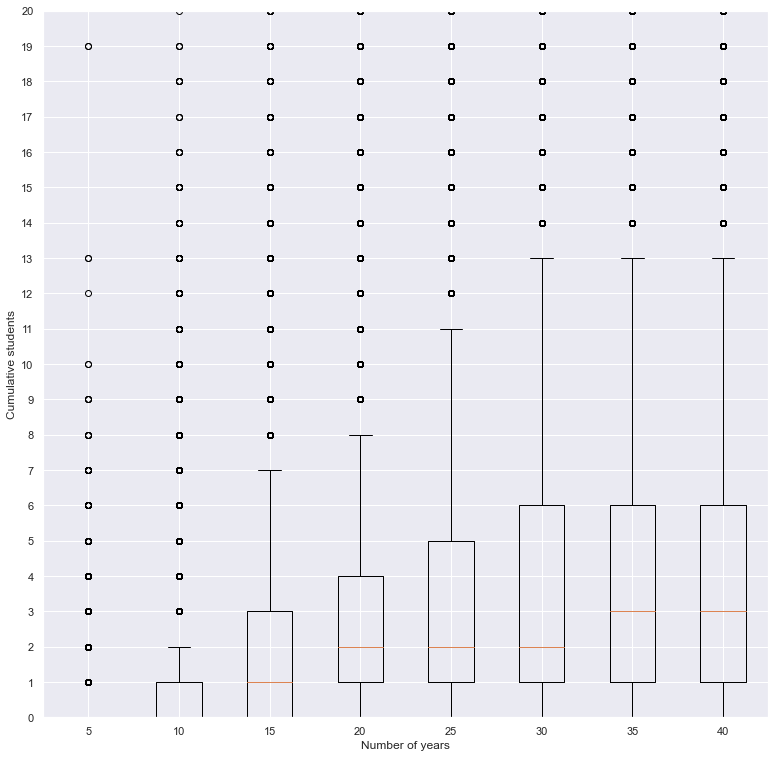

In [3]:
plt.boxplot([ad['num_students_in_%s_years'%(i)] for i in [(j+1)*5 for j in range(0,8)]])
plt.xlabel('Number of years')
plt.ylabel('Cumulative students')
plt.xticks([1,2,3,4,5,6,7,8], [5,10,15,20,25,30,35,40])
plt.yticks([i for i in range(21)])
plt.ylim(0,20)
plt.show()

## 5. Histograms for number of students over various time intervals<a id='5._Histograms_for_number_of_students_over_various_time_intervals'></a>

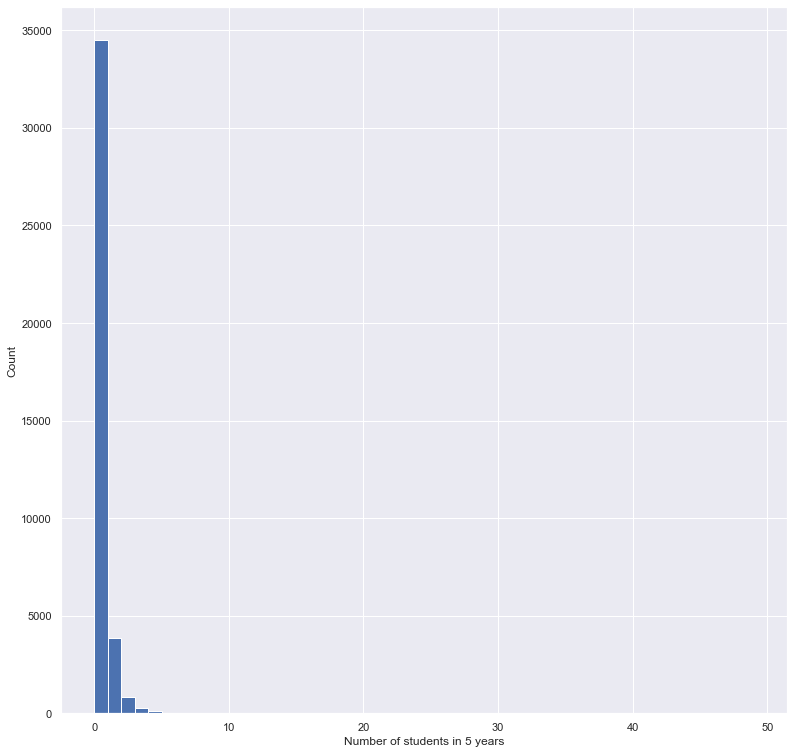

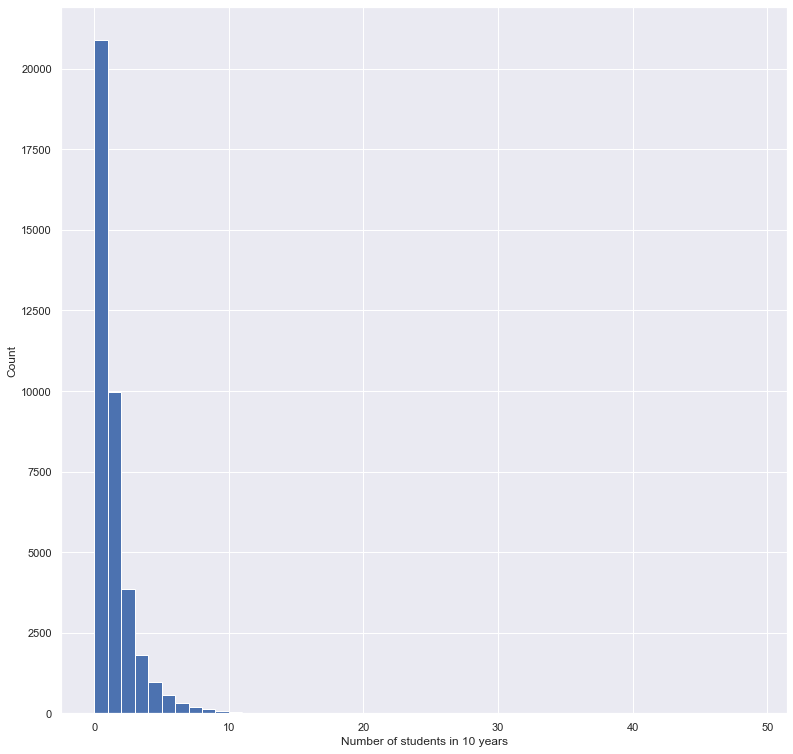

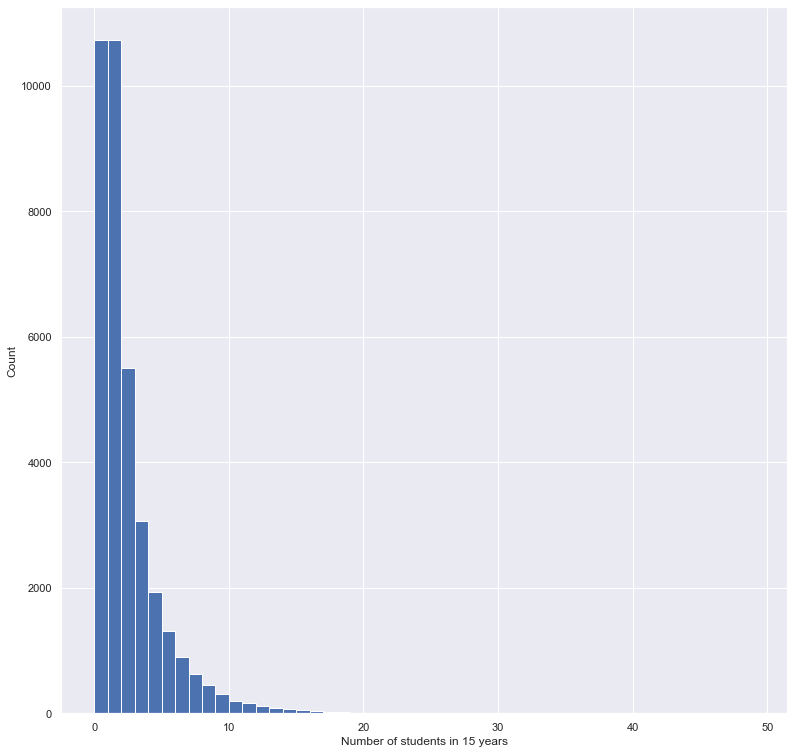

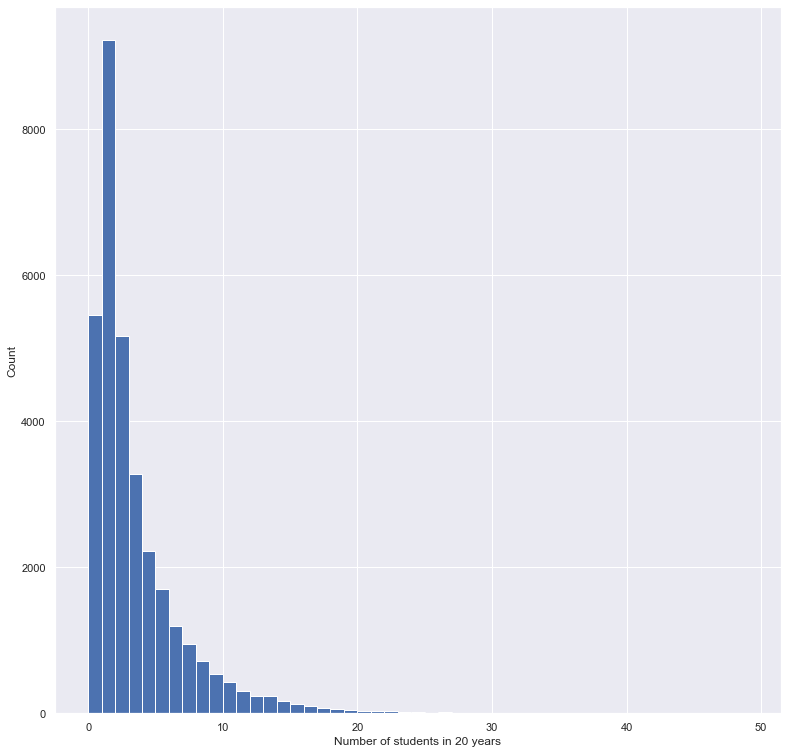

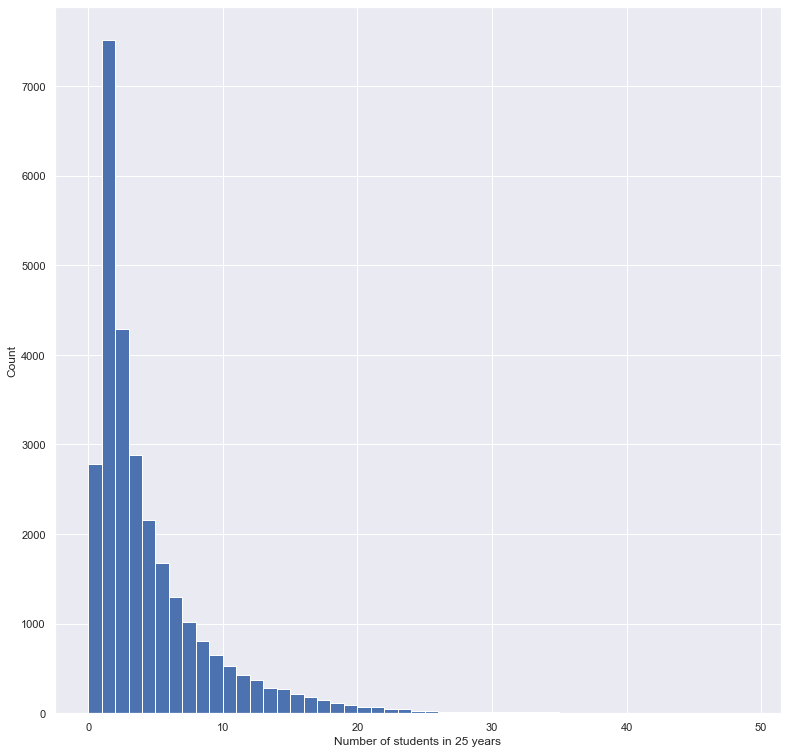

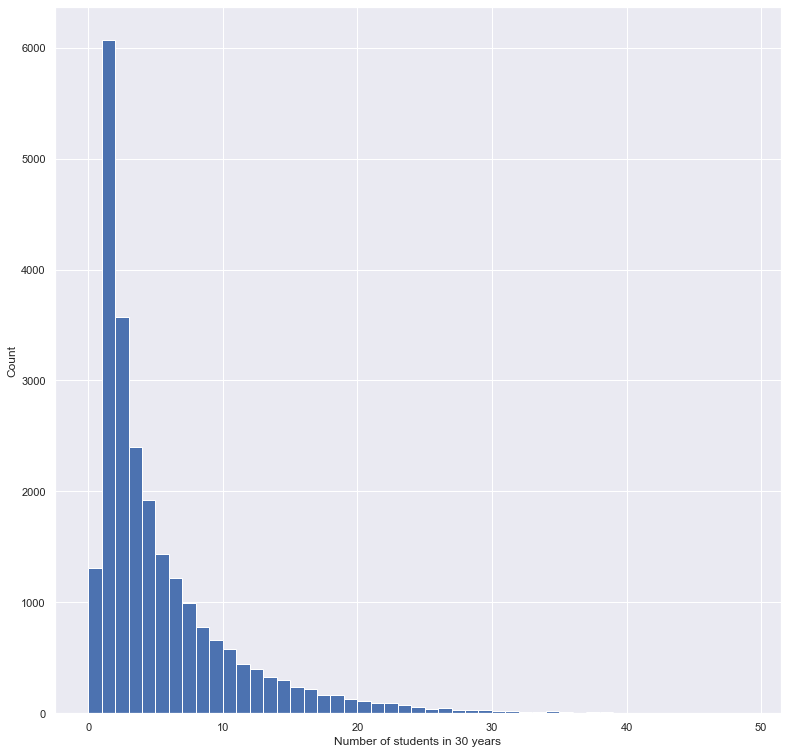

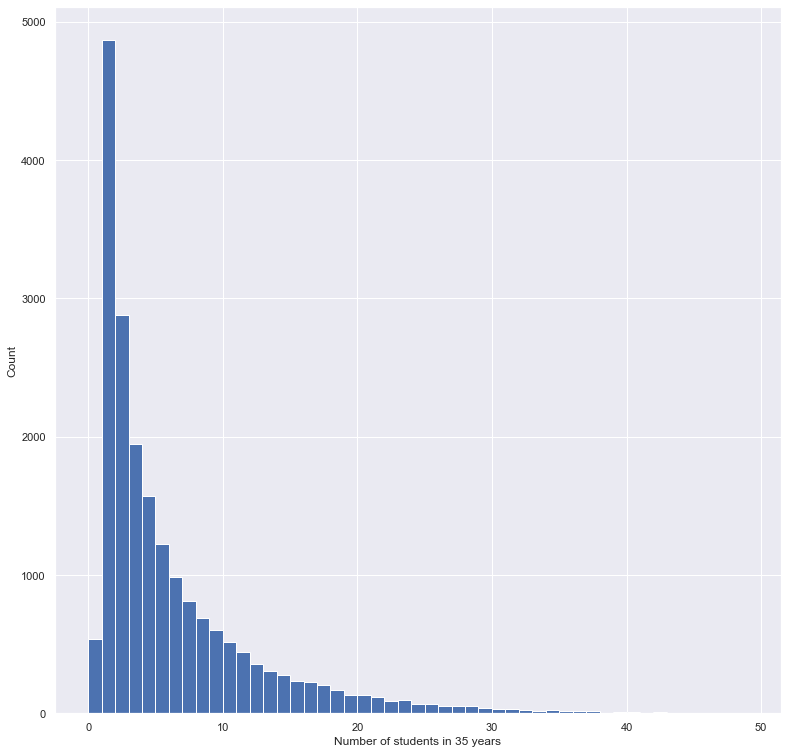

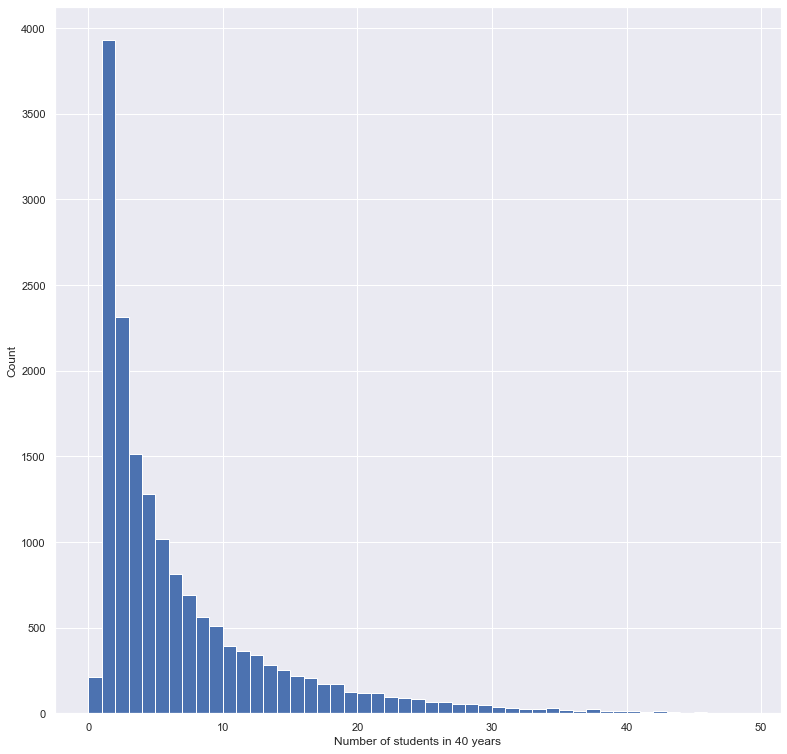

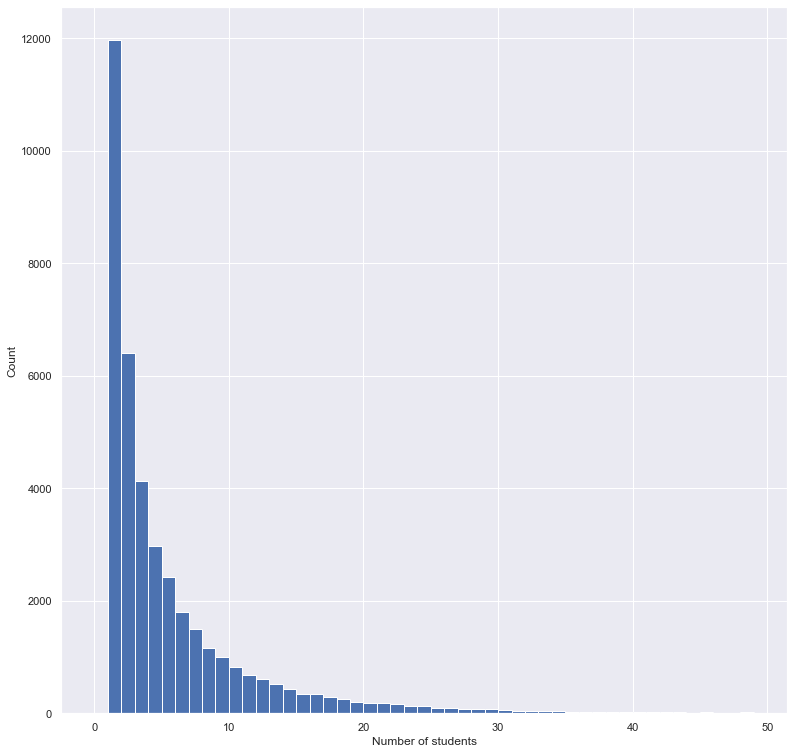

In [4]:
bins = [i for i in range(50)]

for i in range(8):
    _ = plt.hist(ad[(ad['num_students']<50) & (ad['career_length']>= (i+1)*5)]['num_students_in_%s_years'%((i+1)*5)]\
    , bins = bins)
    _ = plt.xlabel('Number of students in %s years'%((i+1)*5))
    _ = plt.ylabel('Count')
    plt.show()
    
fig, ax = plt.subplots()    
_ = plt.hist(ad[ad['num_students']<50]['num_students'],  bins = bins)
_ = plt.xlabel('Number of students')
_ = plt.ylabel('Count')
plt.show()


## 6. Histograms for number of students acquired over various 5-year intervals<a id='6._Histograms_for_number_of_students_acquired_over_various_5-year_intervals'></a>

In [ ]:
# acquired students

for i in range(1,8):
    ad['num_students_acquired_from_%s_to_%s_years'%(i*5,(i+1)*5)] = ad['num_students_in_%s_years'%((i+1)*5)] - ad['num_students_in_%s_years'%((i)*5)]
    

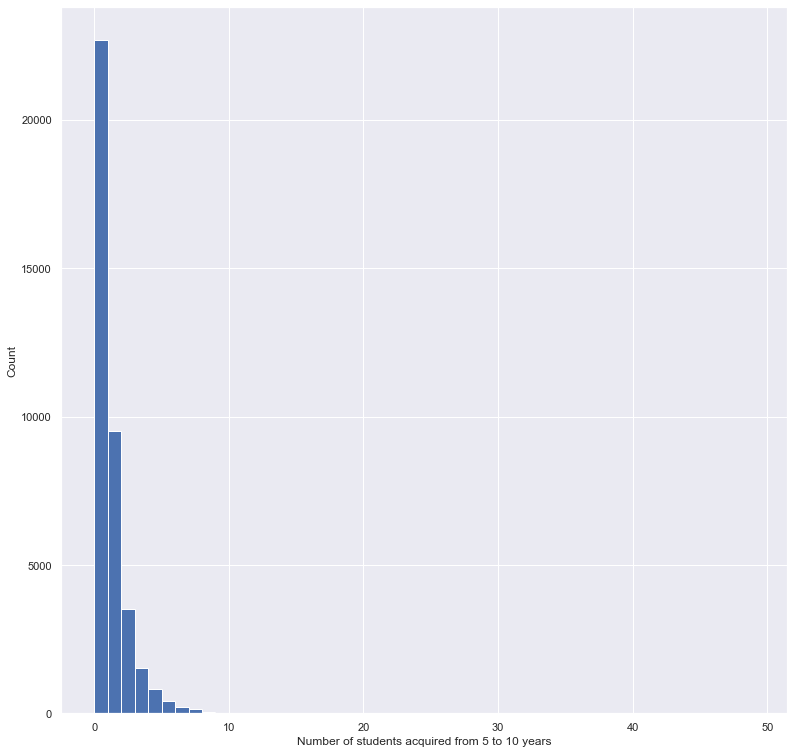

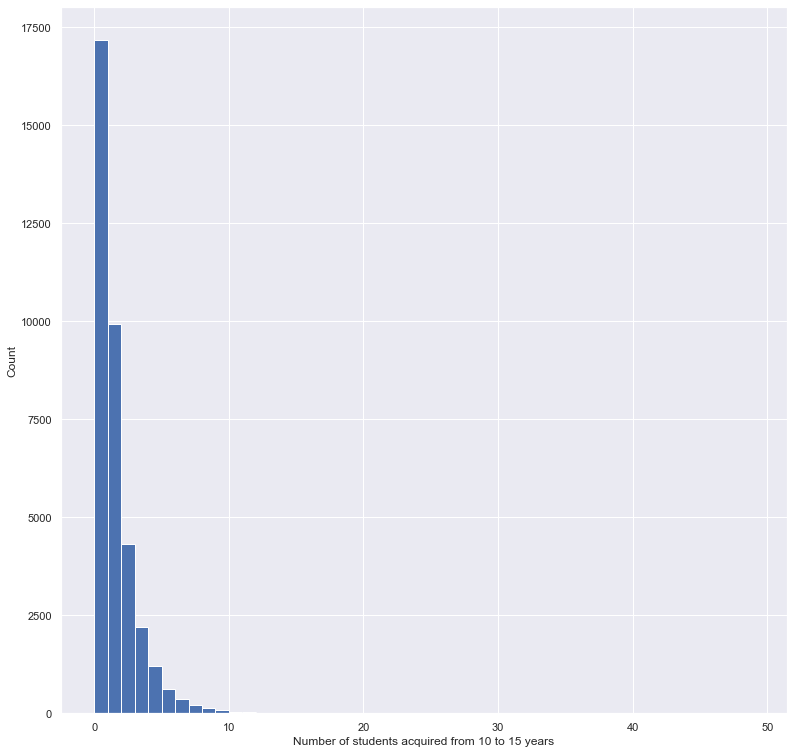

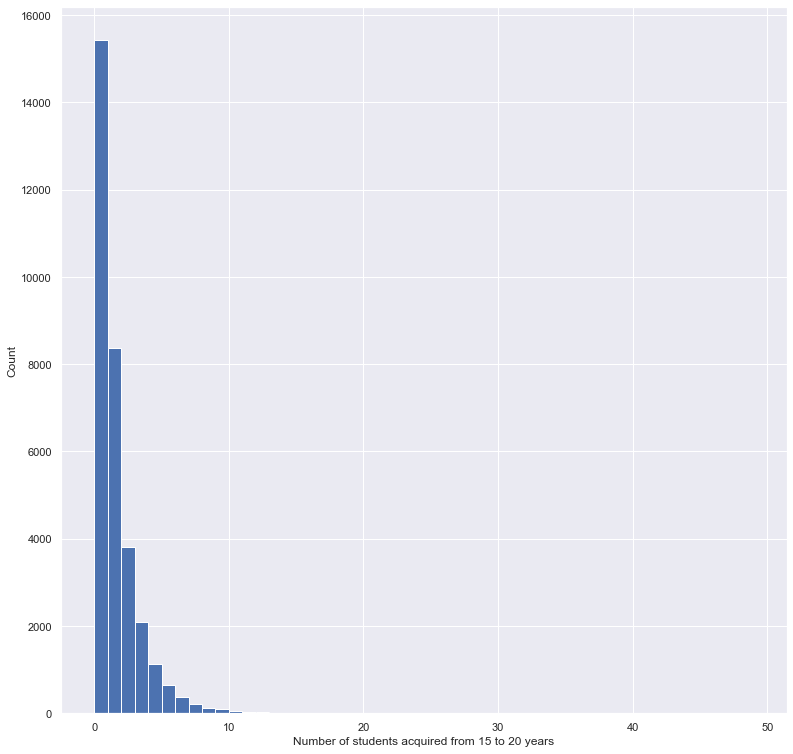

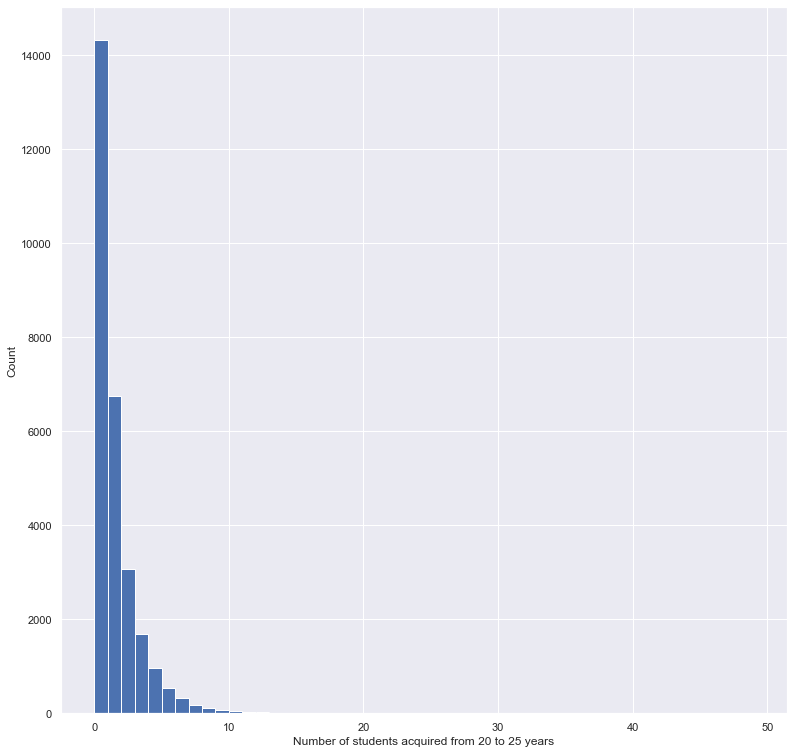

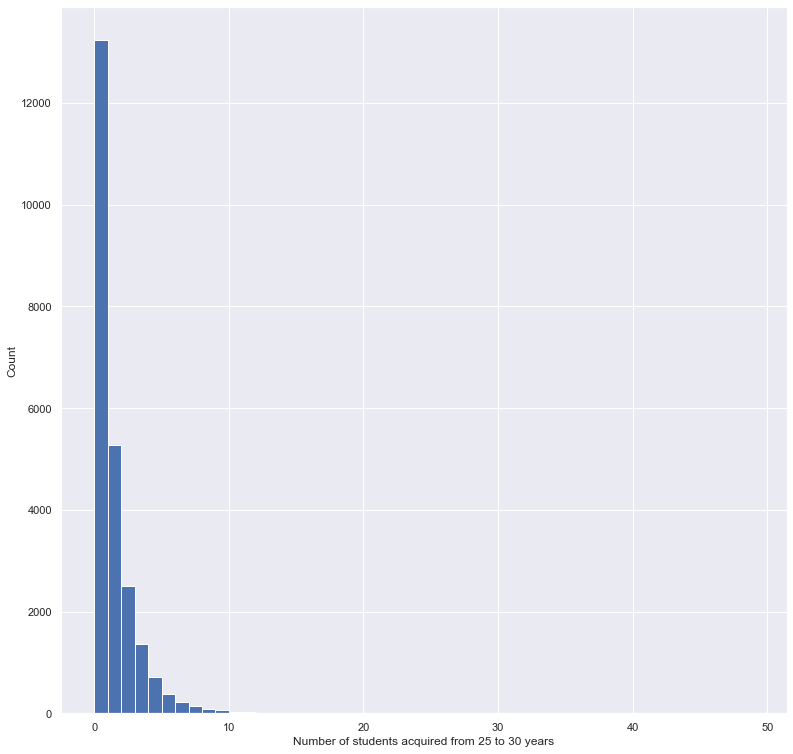

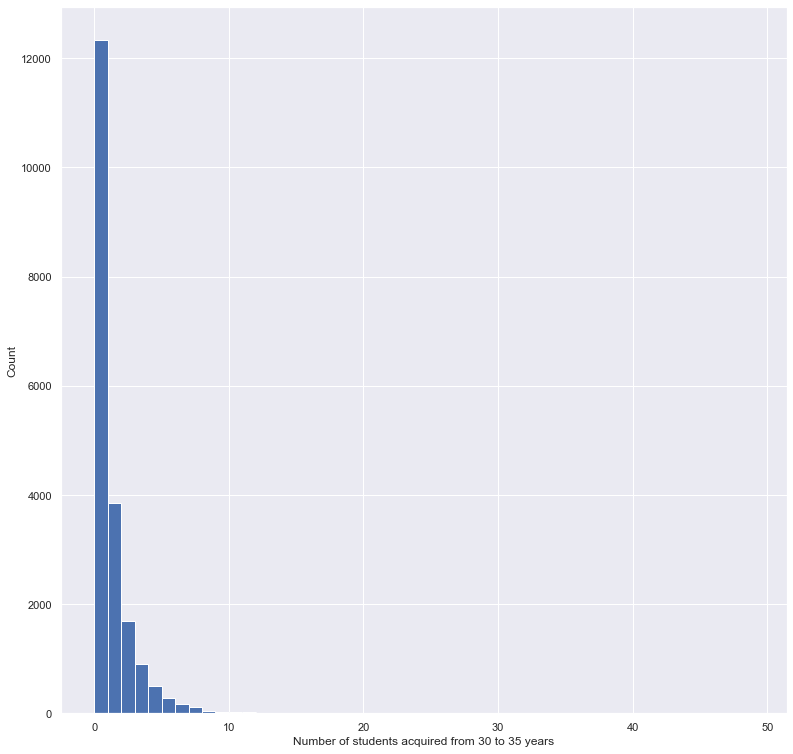

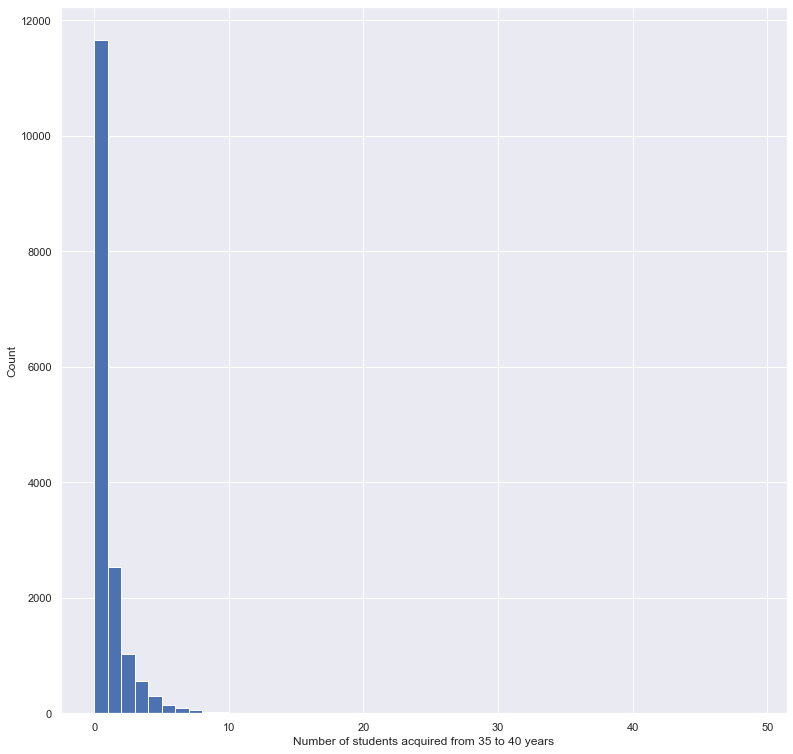

In [5]:
bins = [i for i in range(50)]

for i in range(1,8):
    _ = plt.hist(ad[(ad['num_students']<50) & (ad['career_length']>= (i+1)*5)]['num_students_acquired_from_%s_to_%s_years'%(i*5,(i+1)*5)]\
    , bins = bins)
    _ = plt.xlabel('Number of students acquired from %s to %s years'%(i*5,(i+1)*5))
    _ = plt.ylabel('Count')
    plt.show()

## 7. Boxplots for number of students acquired over various 5-year intervals<a id='7._Boxplots_for_number_of_students_acquired_over_various_5-year_intervals'></a>

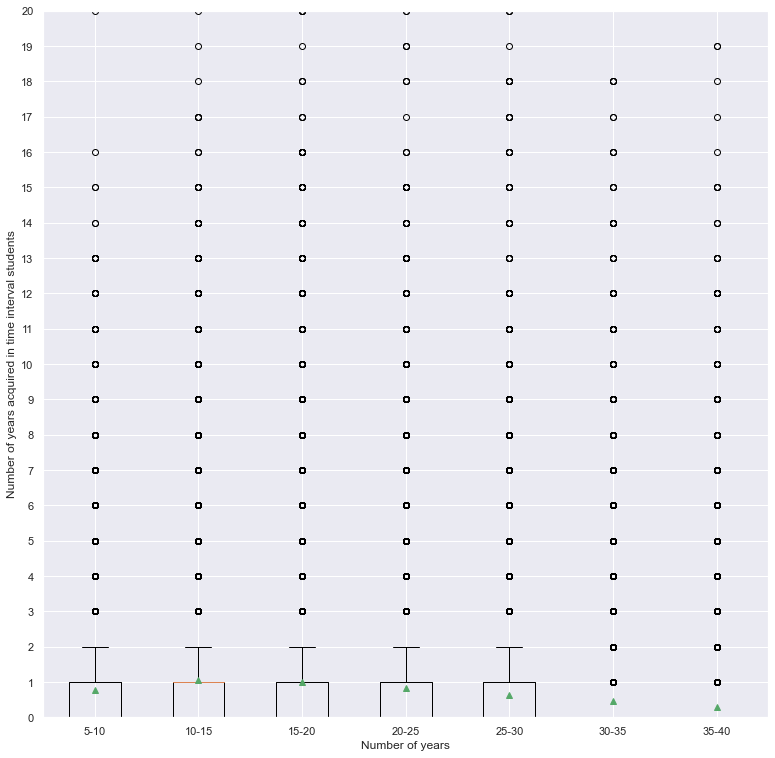

In [6]:
plt.boxplot([ad['num_students_acquired_from_%s_to_%s_years'%(i*5,(i+1)*5)] for i in range(1,8)], showmeans=True)
plt.xlabel('Number of years')
plt.ylabel('Number of years acquired in time interval students')
plt.xticks([1,2,3,4,5,6,7], ['5-10','10-15','15-20','20-25','25-30','30-35','35-40'])
plt.yticks([i for i in range(21)])
plt.ylim(0,20)
plt.show()

In [7]:
ad.describe()

,Unnamed: 0,MGP_ID,MGP_ID.1,MScNetID,Year,MSC,num_students,num_descendants,num_advisors,Advisor_1_MGP_ID,Advisor_2_MGP_ID,Advisor_3_MGP_ID,Advisor_4_MGP_ID,Advisor_5_MGP_ID,Advisor_6_Name,Advisor_6_MGP_ID,Earliest_Pub,Total_Pubs,Total_Rel_Pubs,Total_Citations,Num_Collaborators,Num_Subjects,career_length,num_students_in_5_years,num_students_in_10_years,num_students_in_15_years,num_students_in_20_years,num_students_in_25_years,num_students_in_30_years,num_students_in_35_years,num_students_in_40_years,num_students_acquired_from_5_to_10_years,num_students_acquired_from_10_to_15_years,num_students_acquired_from_15_to_20_years,num_students_acquired_from_20_to_25_years,num_students_acquired_from_25_to_30_years,num_students_acquired_from_30_to_35_years,num_students_acquired_from_35_to_40_years,Advisor_students,school_producers,pubs_per_year,citations_per_year,citations_per_pub,collabs_per_pub
count,39742.000000,39742.000000,39742.000000,3.974200e+04,39742.000000,39742.000000,39742.000000,39742.000000,39742.000000,39742.000000,39742.000000,39742.000000,39742.000000,39742.000000,0.0,39742.0,39742.000000,39742.000000,39742.0,39742.000000,39742.000000,39742.000000,39742.000000,39742.000000,39742.000000,39742.000000,39742.000000,39742.000000,39742.000000,39742.000000,39742.000000,39742.000000,39742.000000,39742.000000,39742.000000,39742.000000,39742.000000,39742.000000,39742.000000,39742.000000,39742.000000,39742.000000,39742.000000,39742.000000
mean,19960.233758,88614.772306,88614.772306,3.831575e+05,1982.471063,29.691334,5.456243,41.448820,1.108928,58748.985607,11388.340874,658.369508,46.697801,6.376126,NaN,0.0,1982.811836,43.925696,0.0,402.946958,21.991118,5.689925,31.379875,0.184339,0.962533,2.020834,3.021237,3.851794,4.495848,4.949902,5.230789,0.778194,1.058301,1.000403,0.830557,0.644054,0.454054,0.280887,15.330789,0.265330,1.466964,12.705466,6.675973,0.673684
std,11537.221839,64137.581439,64137.581439,2.761294e+05,19.218012,35.022414,7.232812,1015.116008,0.459350,56520.463360,35493.074191,9877.266172,2751.504474,925.422751,NaN,0.0,18.942947,52.702016,0.0,911.937860,25.166112,4.056625,10.445679,0.603529,1.605183,2.679704,3.767787,4.759834,5.595656,6.270015,6.764106,1.306714,1.614022,1.715358,1.623078,1.459818,1.252758,1.026479,15.237101,0.117347,1.639221,25.253952,9.736421,0.589164
min,0.000000,4.000000,4.000000,2.200500e+04,1666.000000,-1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.0,1830.000000,1.000000,0.0,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018868,0.000000,0.000000,0.000000
25%,9966.250000,34287.000000,34287.000000,1.680462e+05,1970.000000,-1.000000,1.000000,1.000000,1.000000,15886.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.0,1971.000000,12.000000,0.0,20.000000,6.000000,3.000000,23.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.187678,0.425000,0.675000,1.333333,0.320000
50%,19951.500000,77294.000000,77294.000000,2.837510e+05,1985.000000,5.000000,3.000000,4.000000,1.000000,40909.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.0,1985.000000,29.000000,0.0,116.000000,15.000000,5.000000,35.000000,0.000000,0.000000,1.000000,2.000000,2.000000,2.000000,3.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,0.254005,1.050000,4.175000,3.945700,0.523810
75%,29960.750000,131192.750000,131192.750000,6.419450e+05,1997.000000,62.000000,7.000000,11.750000,1.000000,84352.500000,0.000000,0.000000,0.000000,0.000000,NaN,0.0,1998.000000,58.000000,0.0,403.000000,29.000000,8.000000,40.000000,0.000000,1.000000,3.000000,4.000000,5.000000,6.000000,6.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,21.000000,0.316966,2.000000,14.221014,8.458333,0.857143
max,39955.000000,264075.000000,26407

## 8. CDFs and PDFs for number of students over various time intervals<a id='8._CDFs_and_PDFs_for_number_of_students_over_various_time_intervals'></a>

In [8]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x) + 1)/len(x)
    return x, y

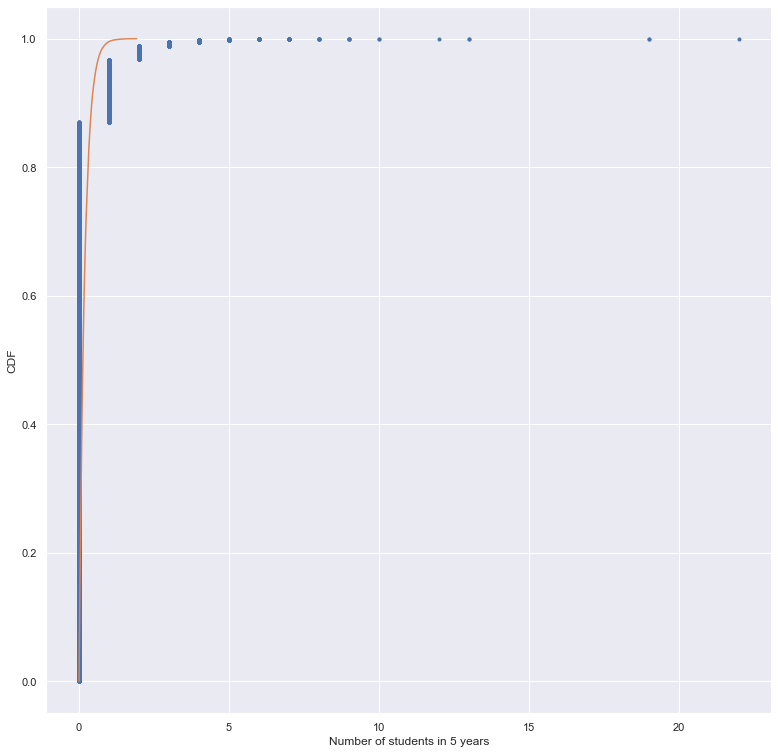

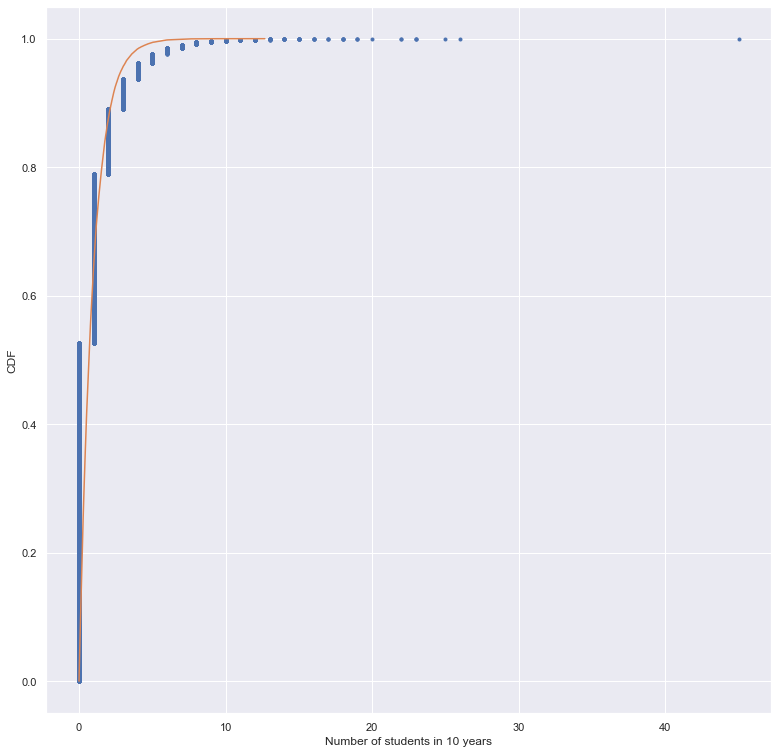

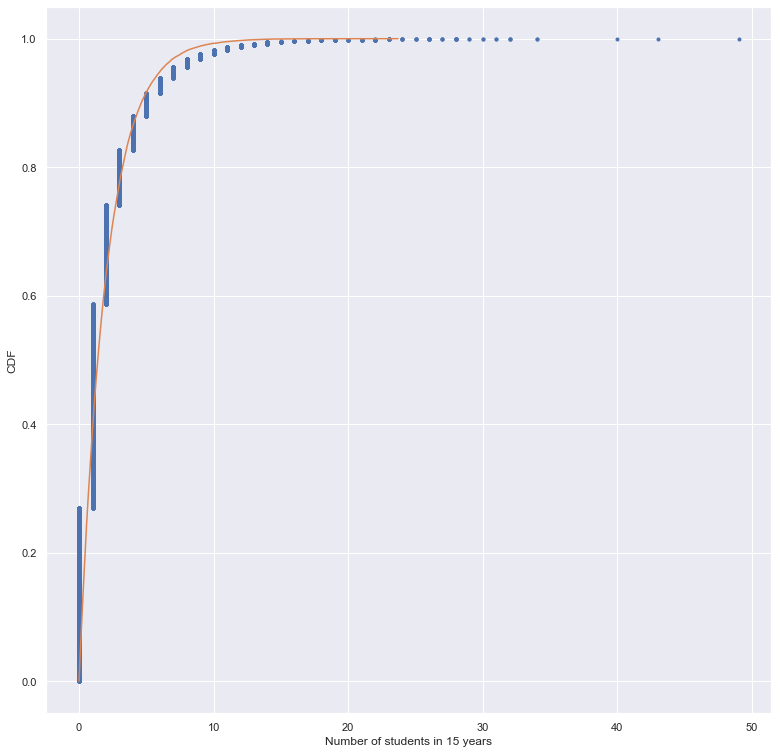

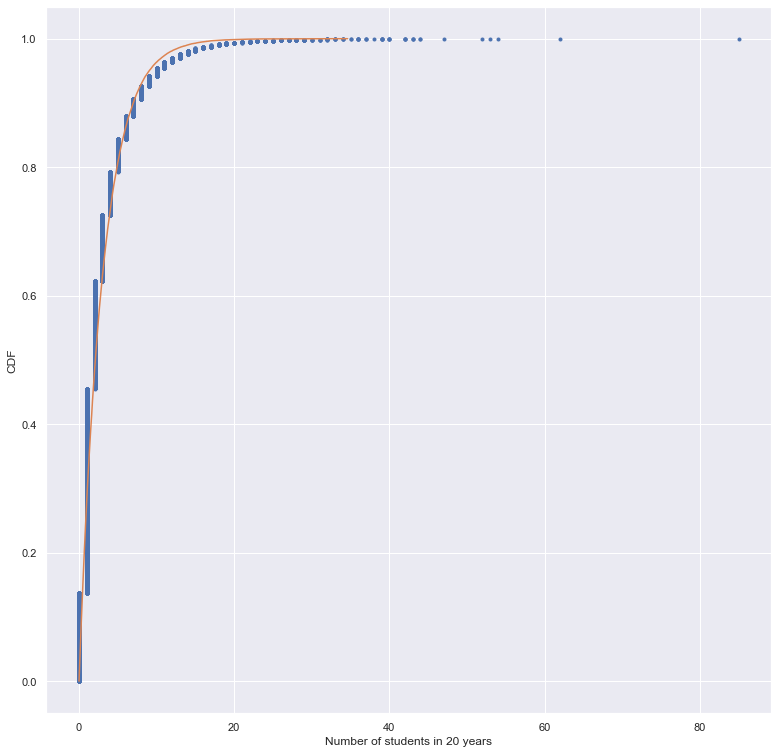

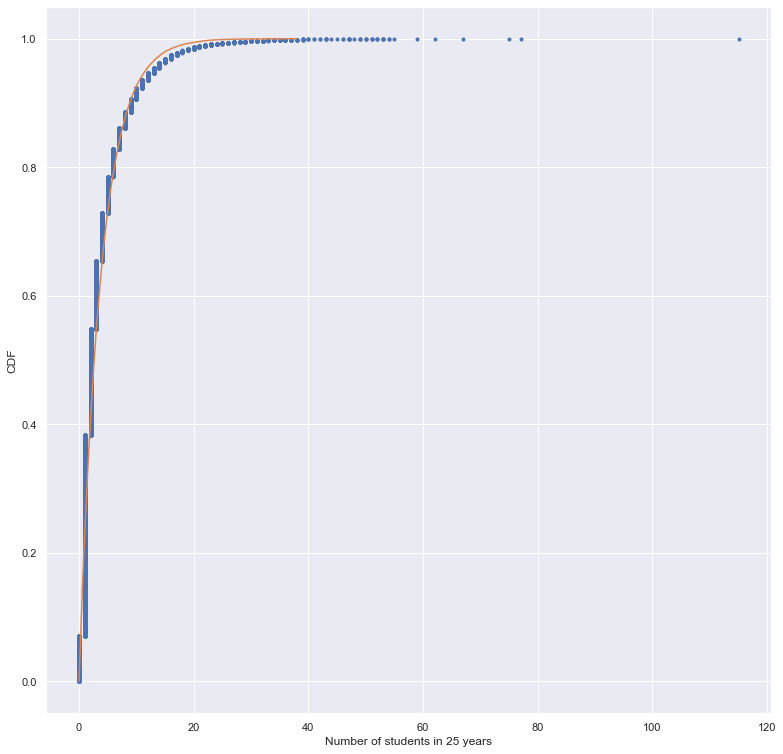

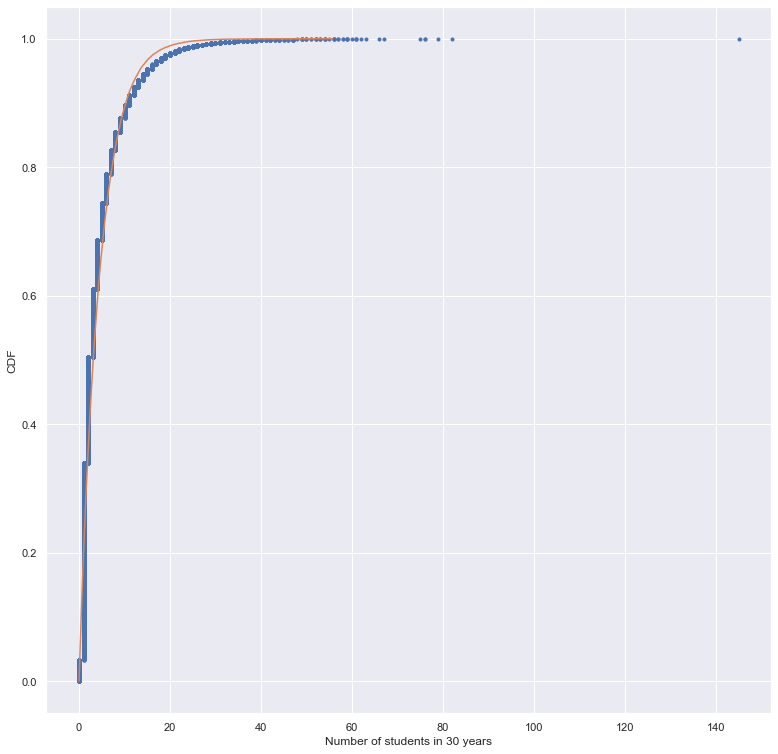

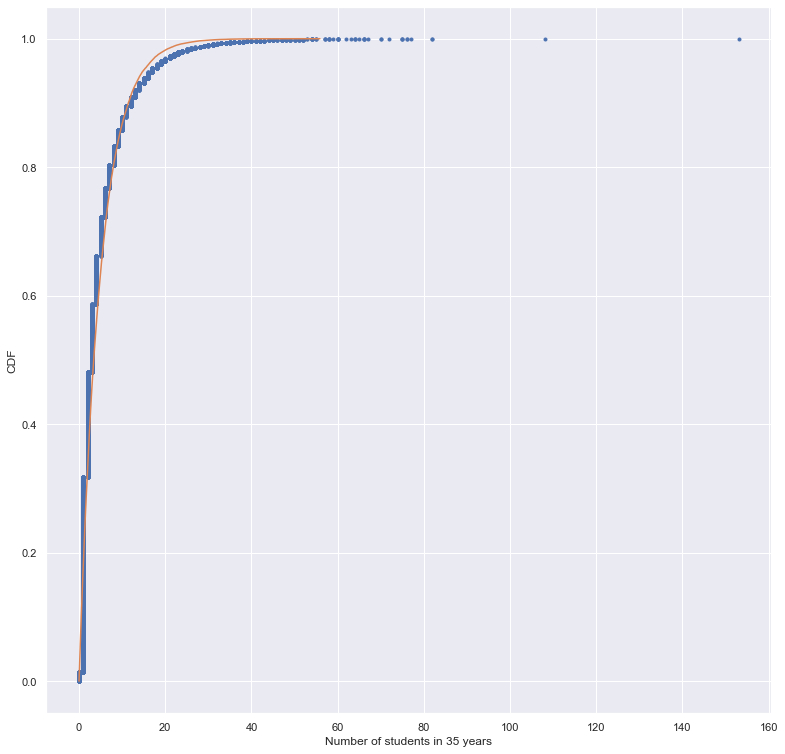

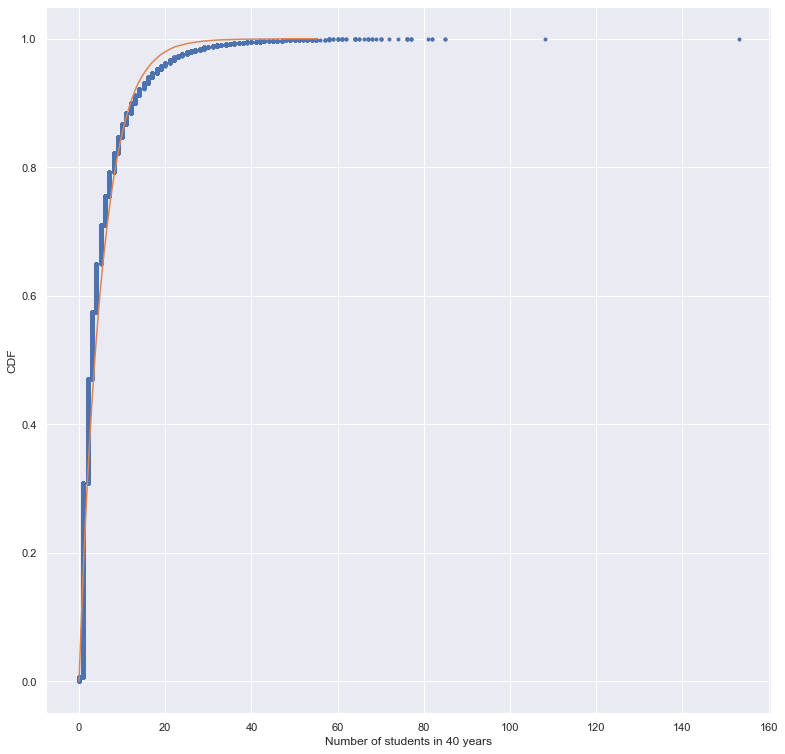

In [9]:
for i in range(8):
    mean = np.mean(ad['num_students_in_%s_years'%((i+1)*5)])
    samples = np.random.exponential(mean, size = 50000)
    x, y = ecdf(ad['num_students_in_%s_years'%((i+1)*5)])
    x_theor, y_theor = ecdf(samples)
    _ = plt.plot(x,y, marker='.', linestyle='none')
    _ = plt.plot(x_theor,y_theor)
    _ = plt.xlabel('Number of students in %s years'%((i+1)*5))
    _ = plt.ylabel('CDF')
    plt.show()


Close fit to exponential distribution in terms of CDF. Now check PDF vid violin plots.

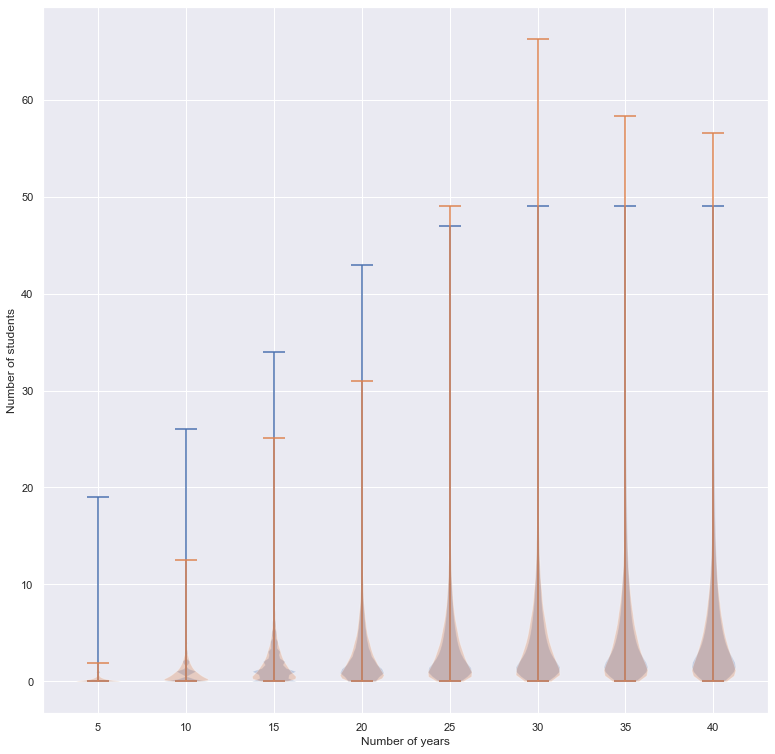

In [10]:

_ = plt.violinplot([ad[(ad['num_students']<50) & (ad['career_length']>= (i+1)*5)]\
                   ['num_students_in_%s_years'%((i+1)*5)] for i in range(8)])
_ = plt.violinplot([np.random.exponential(np.mean(ad['num_students_in_%s_years'%((i+1)*5)]),\
                                          size = 50000) for i in range(8)])
_ = plt.xticks([(i+1) for i in range(8)],[str((i+1)*5) for i in range(8)])
_ = plt.xlabel('Number of years')
_ = plt.ylabel('Number of students')

plt.show()


We will focus on number of students obtained in 20 years

## 9. Obtaining more features<a id='9._Obtaining_more_features'></a>

In [ ]:
def adv_stu(rec):
    num = 0
    count = 0
    for i in range(6):
        adv_id = df.loc[rec,'Advisor_%s_MGP_ID'%(i+1)] 
        if adv_id !=0:
            num += df.loc[adv_id, 'num_students']
            count += 1
    if count != 0:
        return num/count
    else:
        return 0

In [ ]:
ad['Advisor_students'] = ad['MGP_ID'].apply(adv_stu)


In [ ]:
school_totals = df.School.value_counts()

In [ ]:
school_producers = df[df['num_students']>0].School.value_counts()

In [ ]:
def sch_prod(school):
    try:
        return school_producers[school] / school_totals[school]
    except:
        return 0

In [ ]:
ad['school_producers'] = ad['School'].apply(sch_prod)

In [ ]:
ad['pubs_per_year'] = ad['Total_Pubs'].divide(ad['career_length'])

In [ ]:
ad['citations_per_year'] = ad['Total_Citations'].divide(ad['career_length'])

Citations per pub and collaborator per pub is less skewed by our decision on how to measure career lengths, so we will use those features too.  Before doing that, we need to check how many records have zero publications.

In [ ]:
ad[ad['Total_Pubs']==0].shape

214 records with zero publications.  Let's drop those:

In [ ]:
ad = ad[ad['Total_Pubs']>0]

In [ ]:
ad['citations_per_pub'] = ad['Total_Citations'].divide(ad['Total_Pubs'])
ad['collabs_per_pub'] = ad['Num_Collaborators'].divide(ad['Total_Pubs'])

## 10. Obtaining dataframe for advisors with career length at least 20 years<a id='10._Obtaining_dataframe_for_advisors_with_career_length_at_least_20_years'></a>

In [ ]:
# data frame with career length >= 20

ad20 = ad[ad['career_length']>=20]

Save dataframes so we don't have to go through all the computations again.

In [ ]:
ad.to_excel('advisor_table.xlsx')
ad20.to_excel('advisor20_table.xlsx')

## 11. Visualizations of correlations<a id='11._Visualizations_of_correlations'></a>

### 11.1 Heatmap<a id='11.1_Heatmap'></a>

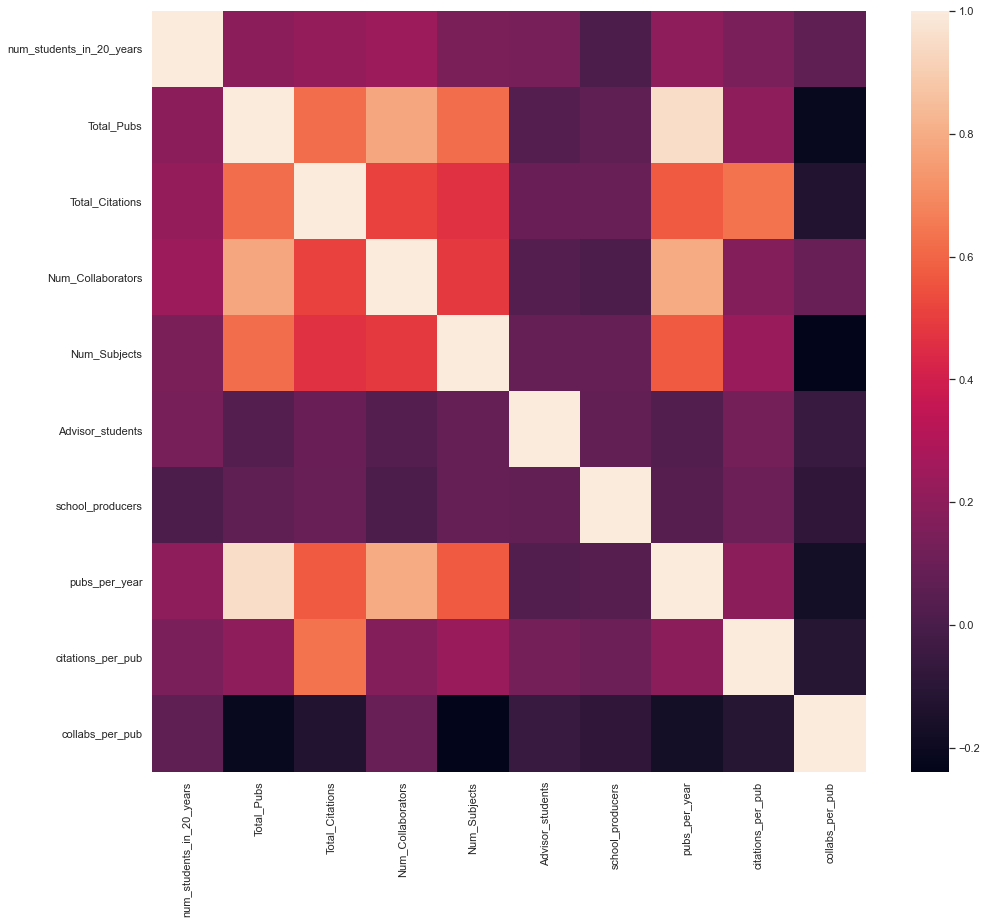

In [11]:
plt.subplots(figsize=(16,14))
sns.heatmap(ad20[['num_students_in_20_years','Total_Pubs',\
                'Total_Citations','Num_Collaborators','Num_Subjects','Advisor_students','school_producers',\
                'pubs_per_year','citations_per_pub','collabs_per_pub']].corr(), annot=False)
plt.show()

### 11.2 Pairplot<a id='11.2_Pairplot'></a>

In [12]:
# list of columns to compare with number of students in 20 years

xes = ['Num_Subjects','Advisor_students','school_producers','pubs_per_year','citations_per_pub','collabs_per_pub']

xes_ns = xes+['num_students_in_20_years']

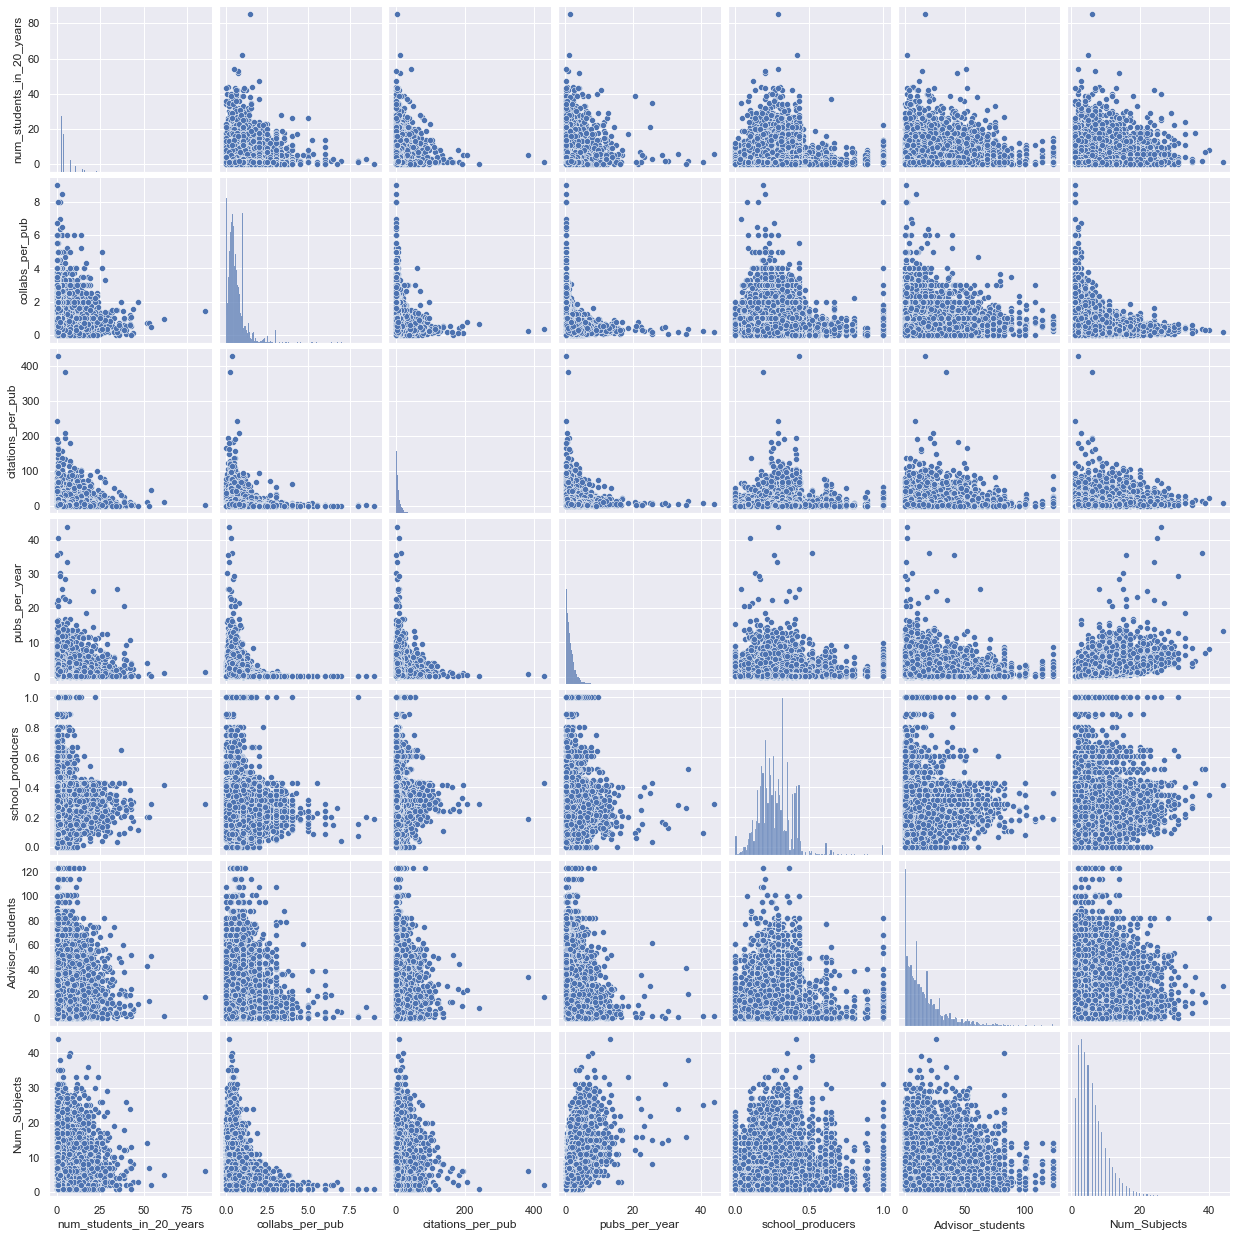

In [13]:
sns.pairplot(ad20[xes_ns[::-1]])
plt.show()

### 11.3 Scatter plots with 4 regression curves<a id='11.3_Scatter_plots_with_4_regression_curves'></a>

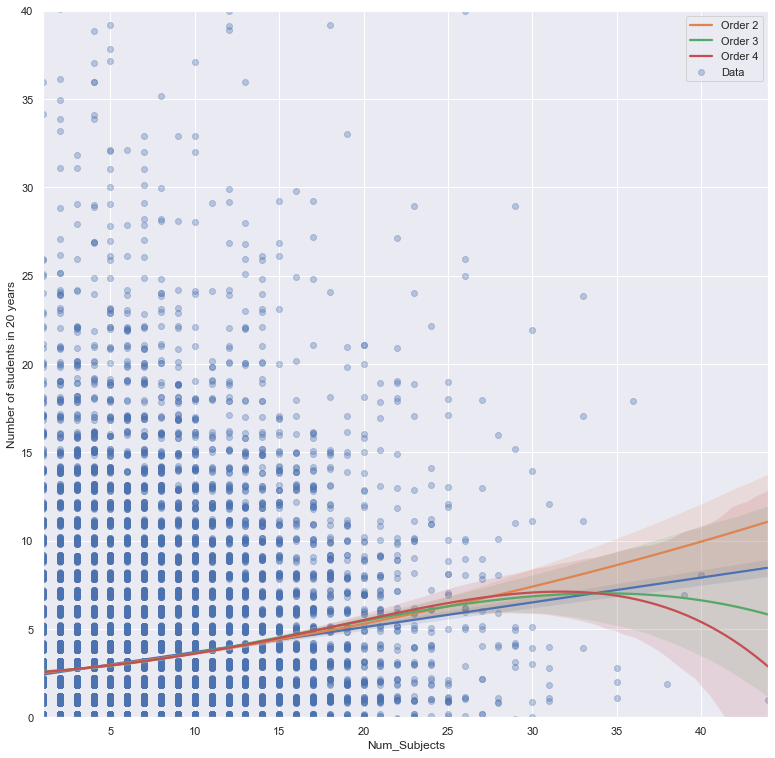

Correlation:  [[1.         0.14943055]
 [0.14943055 1.        ]]


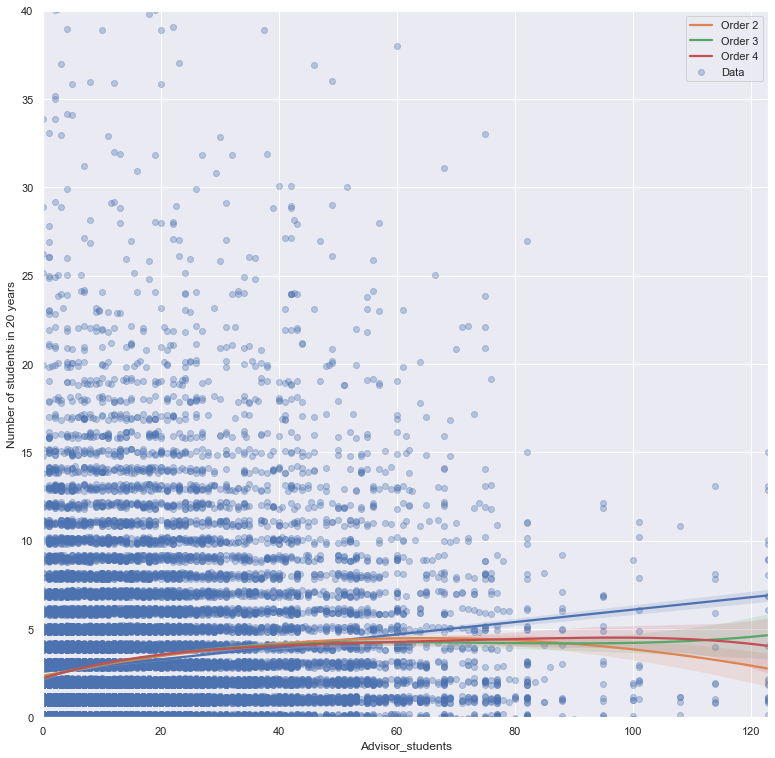

Correlation:  [[1.         0.13799451]
 [0.13799451 1.        ]]


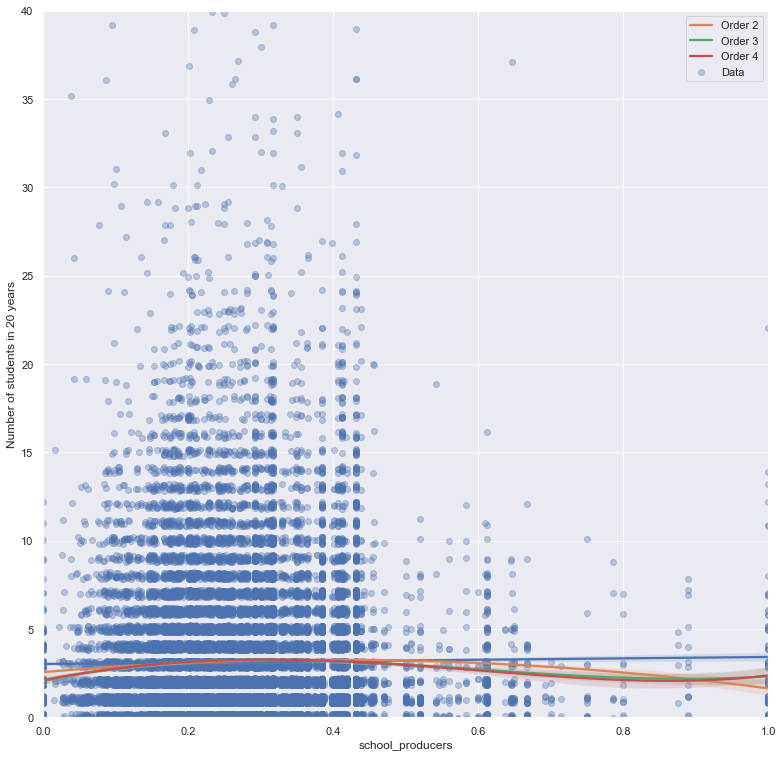

Correlation:  [[1.         0.01147142]
 [0.01147142 1.        ]]


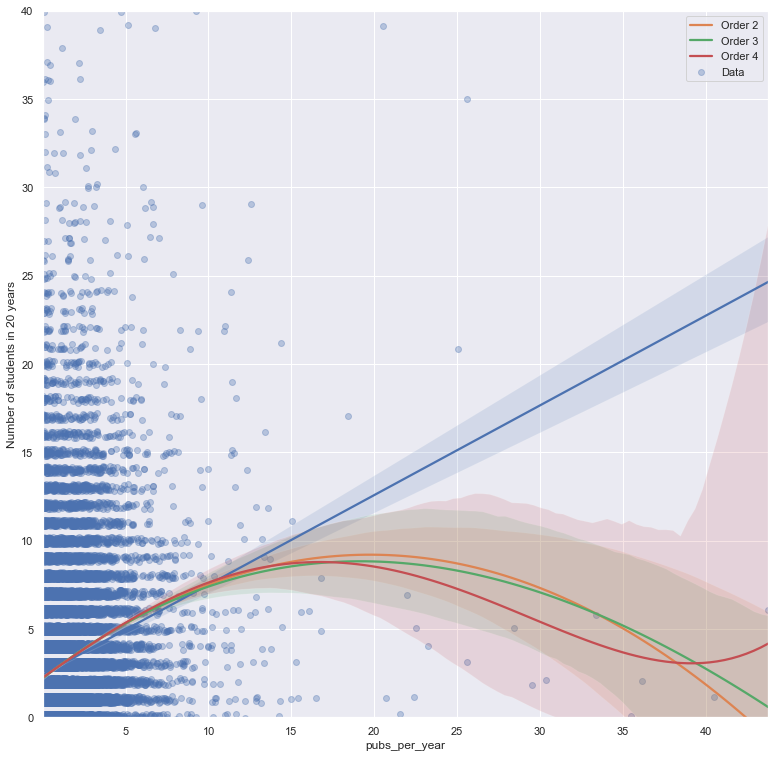

Correlation:  [[1.         0.20184908]
 [0.20184908 1.        ]]


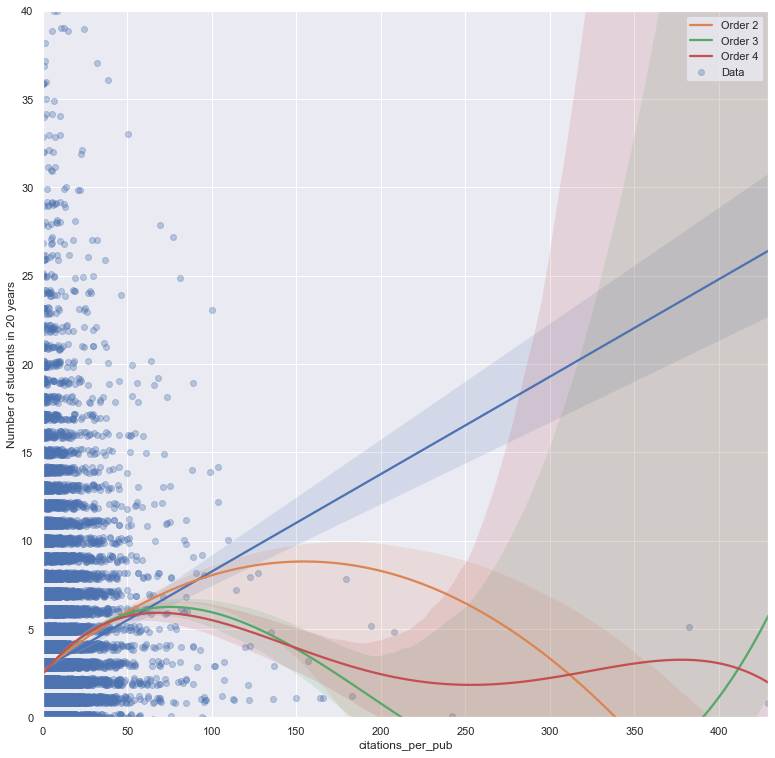

Correlation:  [[1.         0.14387133]
 [0.14387133 1.        ]]


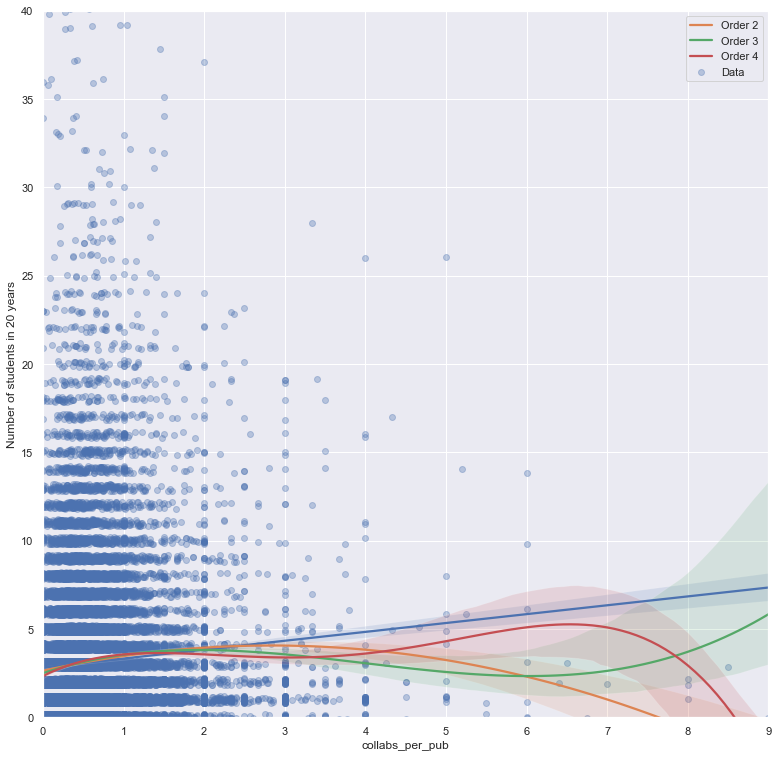

Correlation:  [[1.         0.06649299]
 [0.06649299 1.        ]]


In [14]:
for x in xes:
    sns.regplot(x=x, y='num_students_in_20_years', data=ad20, label='Data', y_jitter = 0.2, scatter_kws = {'alpha' : 1/3})
    for i in range(2,5):
        sns.regplot(x=x, y='num_students_in_20_years', data=ad20, order=i, scatter=None, label='Order %s'%(i))
    plt.ylim(0,40)
    plt.xlabel(x)
    plt.ylabel('Number of students in 20 years')
    plt.legend(loc='upper right')
    plt.show()
    print('Correlation: ', np.corrcoef(ad20[x], ad20['num_students_in_20_years']))

### 11.4 Aside: `Num_Collaborators` and `Total_Pubs` exhibit strong correlation<a id='11.4_Aside'></a>

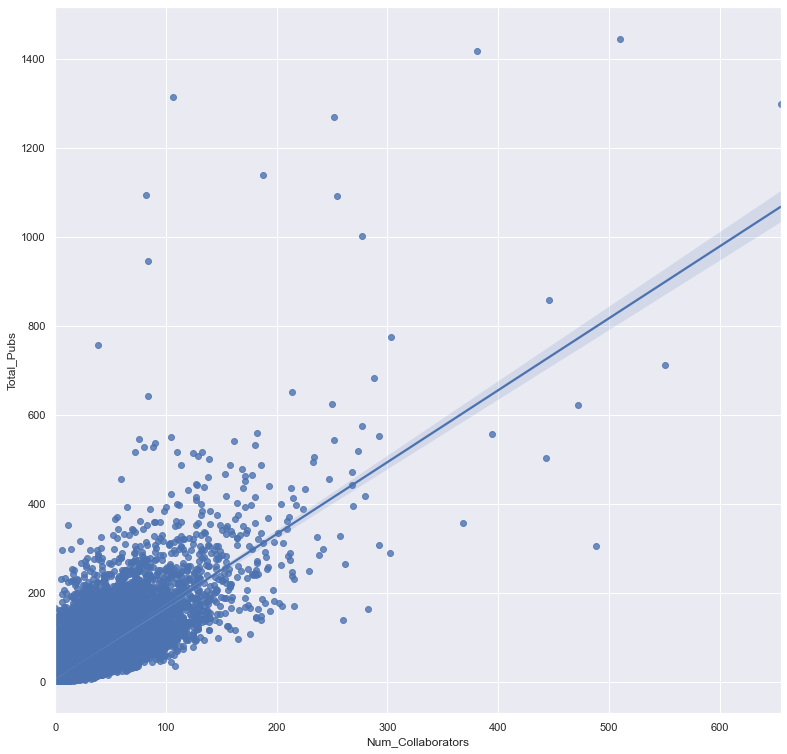

[[1.         0.77193399]
 [0.77193399 1.        ]]


In [15]:
sns.regplot(x='Num_Collaborators', y='Total_Pubs', data=ad)
plt.show()
print(np.corrcoef(ad.Num_Collaborators, ad.Total_Pubs))

## 12. Categorical analysis<a id='12._Categorical_analysis'></a>

From the weak regression prospects indicated above (to be further confirmed in the preprocessing stage), we turn to consider this as a classification probelm.  Based on domain knowledge, we will split the 20-year column into two categories: 0 - 4 students in 20 years, and 5 or more students in 20 years.

In [16]:
ad20['geq5in20'] = ad20['num_students_in_20_years'].apply(lambda C: True if C >= 5 else False)

In [17]:
predictors = ['pubs_per_year','citations_per_pub','collabs_per_pub','Advisor_students']

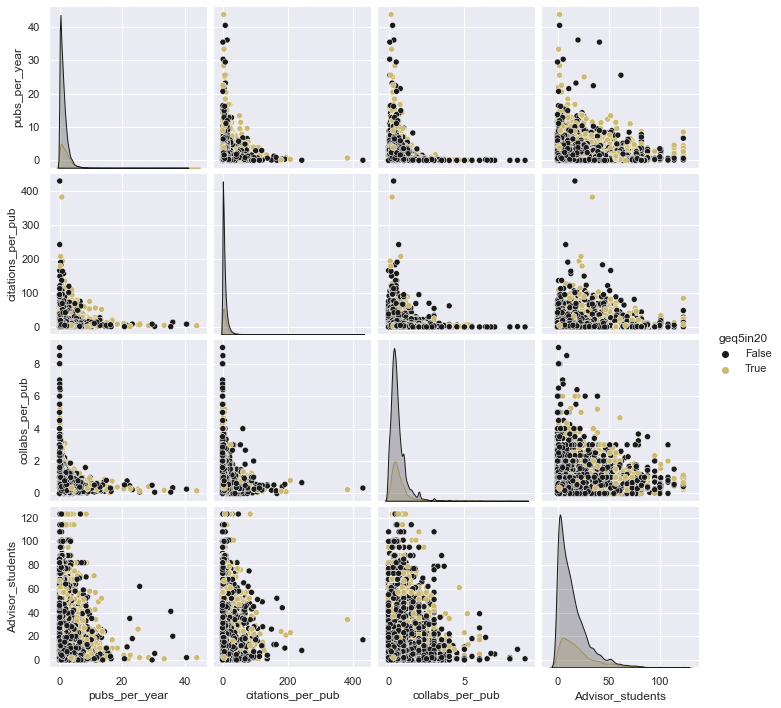

In [18]:
sns.pairplot(data=ad20[['geq5in20']+predictors], hue='geq5in20', palette=['k','y'])
plt.show()

3D scatter plot colored by `geq5in20` plotting `pubs_per_year` with `citations_per_pub` and `Advisor_students`.  (From the pairplot above, `collabs_per_pub` seems to have less of an effect)  We have truncated some outliers to make the visualization more clear. 

<IPython.core.display.Javascript object>


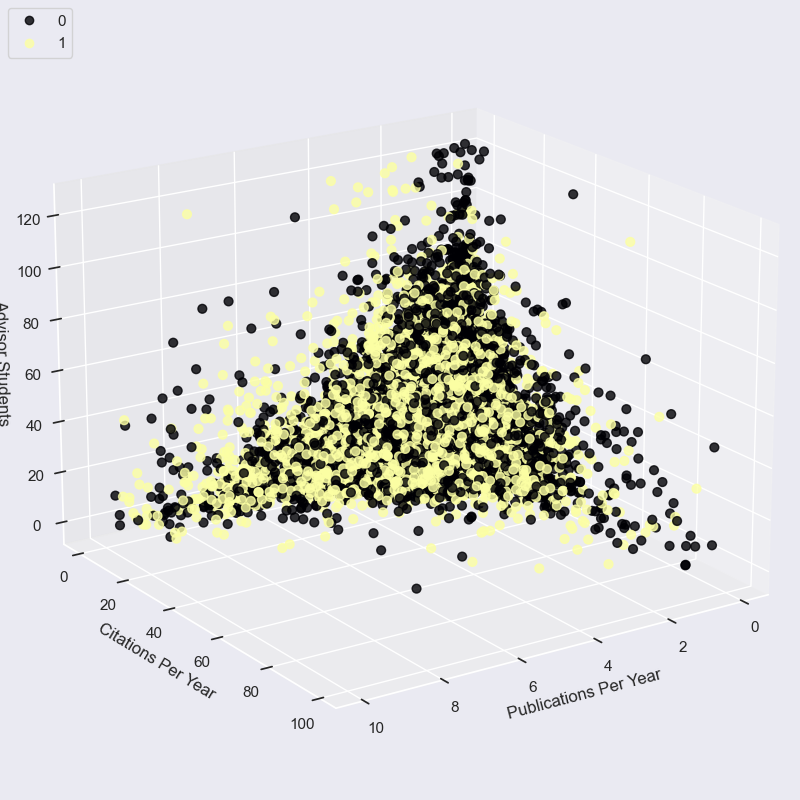

In [29]:
%matplotlib notebook
sns.set(style = "darkgrid")

fig = plt.figure(figsize=(8,8))
ax3d = Axes3D(fig)



x = ad20[(ad20['citations_per_pub']<100) & (ad20['pubs_per_year']<10)]['pubs_per_year']
y = ad20[(ad20['citations_per_pub']<100) & (ad20['pubs_per_year']<10)]['citations_per_pub']
z = ad20[(ad20['citations_per_pub']<100) & (ad20['pubs_per_year']<10)]['Advisor_students']

sc = ax3d.scatter(x, y, z, s=40, c=ad20[(ad20['citations_per_pub']<100) & (ad20['pubs_per_year']<10)]['geq5in20'], cmap='inferno', alpha=0.8)

ax3d.set_xlabel("Publications Per Year")
ax3d.set_ylabel("Citations Per Year")
ax3d.set_zlabel("Advisor Students")

plt.legend(*sc.legend_elements(), loc=2)


plt.show()

There does seem to be some relationship between these variables and the categorical variable of whether or not a candidate produces at least 5 students in 20 years.